# Régression logistique

Ce Notebook présente l'implantation  d'un modèle de régression logistique pour la prédiction du cancer.
Les données utilisées sont:

- Âge : valeurs entières représentant l'âge du patient, comprises entre 20 et 80 ans.
- Sexe : valeurs binaires représentant le sexe, où 0 indique « Homme » et 1 indique « Femme ».
- IMC : valeurs continues représentant l'indice de masse corporelle, comprises entre 15 et 40.
- Tabagisme : valeurs binaires indiquant le statut tabagique, où 0 signifie « Non » et 1 signifie « Oui ».
- Risque génétique : valeurs catégorielles représentant les niveaux de risque génétique de cancer, où 0 indique un risque faible, 1 un risque moyen et 2 un risque élevé.
- Activité physique : valeurs continues représentant le nombre d'heures par semaine consacrées à l'activité physique, comprises entre 0 et 10.
- Consommation d'alcool : valeurs continues représentant le nombre d'unités d'alcool consommées par semaine, comprises entre 0 et 5.
- Antécédents de cancer : valeurs binaires indiquant si le patient a des antécédents personnels de cancer, où 0 signifie « non » et 1 signifie « oui ».
- Diagnostic (valeur cible) : valeurs binaires indiquant le statut du diagnostic de cancer, où 0 indique « pas de cancer » et 1 indique « cancer ».

<span style="color: yellow">Traduit avec DeepL.com (version gratuite)</span>

Source des données: https://www.kaggle.com/datasets/rabieelkharoua/cancer-prediction-dataset


## Librairies necessaires pour notre projet

In [1]:
#Librairies necessaires pour notre projet
import pandas as pd #pd est l'allias de pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

## Exploration des données

In [2]:
#Importation du dataset dans un DataFrame
dataframe=pd.read_csv('data/The_Cancer_data_1500_V2.csv')
#Affichons les 5 premières lignes
dataframe.head(5)

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


In [3]:
#Renommons les colonnes en français
dataframe=dataframe.rename(columns={
    'Age':'age',
    'Gender':'sexe',
    'BMI':'imc',
    'Smoking':'tabagisme',
    'GeneticRisk':'risque_genetique',#notation Snake Case
    'PhysicalActivity':'activite_physique',
    'AlcoholIntake':'consomme_alcool',
    'CancerHistory':'historique_cancer',
    'Diagnosis':'diagnostique'
})
dataframe.head(5)

,age,sexe,imc,tabagisme,risque_genetique,activite_physique,consomme_alcool,historique_cancer,diagnostique
0,58,1,16.085313,0,1,8.146251,4.148219,1,1
1,71,0,30.828784,0,1,9.361630,3.519683,0,0
2,48,1,38.785084,0,2,5.135179,4.728368,0,1
3,34,0,30.040296,0,0,9.502792,2.044636,0,0
4,62,1,35.479721,0,0,5.356890,3.309849,0,1


### Statistiques des données

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1500 non-null   int64  
 1   sexe               1500 non-null   int64  
 2   imc                1500 non-null   float64
 3   tabagisme          1500 non-null   int64  
 4   risque_genetique   1500 non-null   int64  
 5   activite_physique  1500 non-null   float64
 6   consomme_alcool    1500 non-null   float64
 7   historique_cancer  1500 non-null   int64  
 8   diagnostique       1500 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 105.6 KB


In [5]:
colonnes_numeriques=['age','imc','activite_physique','consomme_alcool']
dataframe[colonnes_numeriques].describe()#Statistique des données numériques.

,age,imc,activite_physique,consomme_alcool
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,50.320000,27.513321,4.897929,2.417987
std,17.640968,7.230012,2.866162,1.419318
min,20.000000,15.000291,0.002410,0.001215
25%,35.000000,21.483134,2.434609,1.210598
50%,51.000000,27.598494,4.834316,2.382971
75%,66.000000,33.850837,7.409896,3.585624
max,80.000000,39.958688,9.994607,4.987115


In [6]:
features_categorielles = ['sexe','tabagisme','risque_genetique','historique_cancer']
dataframe[features_categorielles+['diagnostique']].astype("object").describe()##Statistique des données catégorielles.

,sexe,tabagisme,risque_genetique,historique_cancer,diagnostique
count,1500,1500,1500,1500,1500
unique,2,2,3,2,2
top,0,0,0,0,0
freq,764,1096,895,1284,943


### Visualisation des données

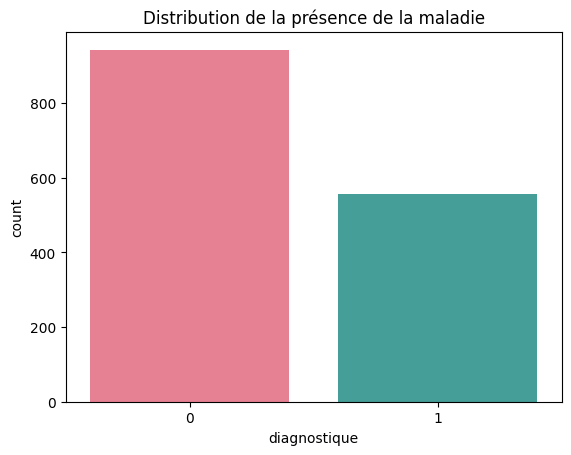

In [7]:
sns.countplot(x="diagnostique",  hue="diagnostique", data=dataframe, palette="husl",legend=False)
plt.title("Distribution de la présence de la maladie")
plt.show()

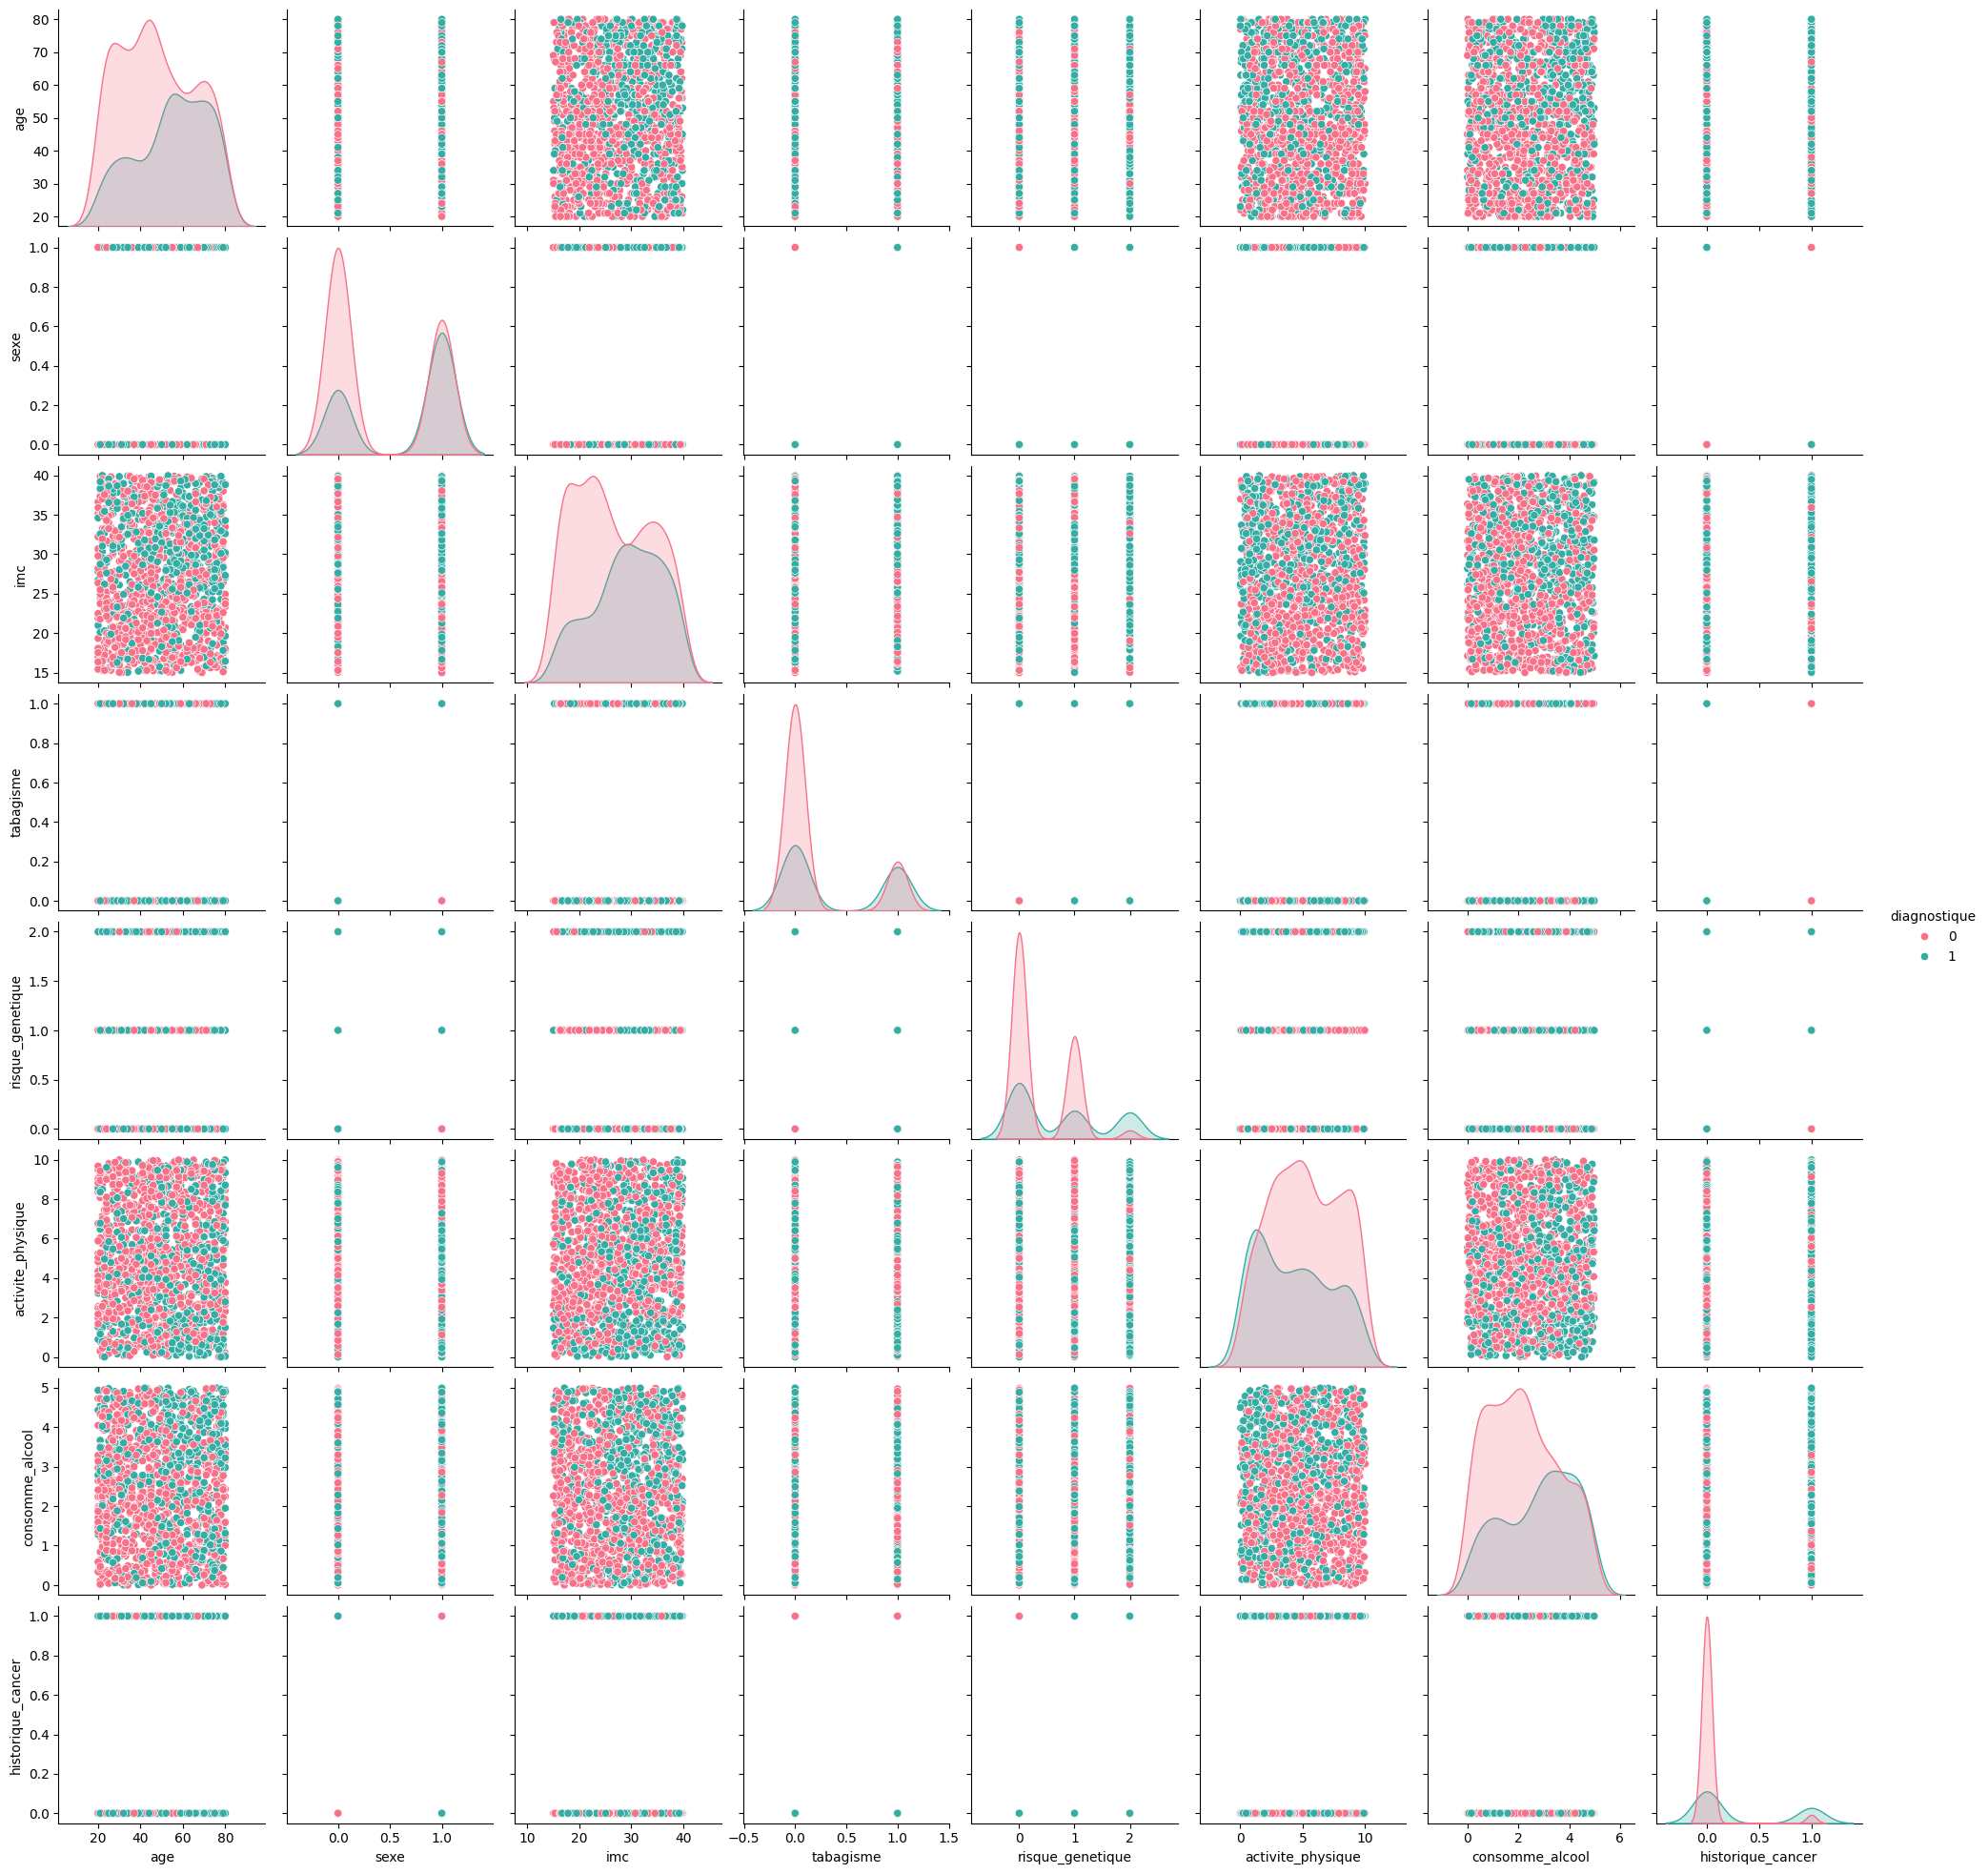

In [8]:
# import warnings
# warnings.filterwarnings("ignore")
sns.pairplot(dataframe, hue="diagnostique", diag_kind="kde", palette="husl")# Essayez hist
# sns.pairplot(dataframe.loc[dataframe.diagnostique==0,:], hue="diagnostique", diag_kind="kde", palette="husl")
plt.show()

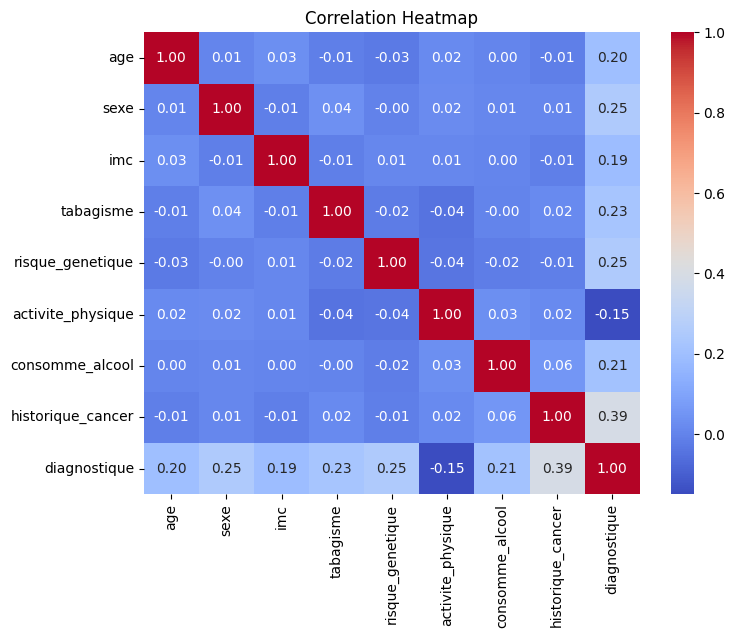

In [9]:
# Visualisons les relations linéaires entre les features
plt.figure(figsize=(8,6))
sns.heatmap(dataframe.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

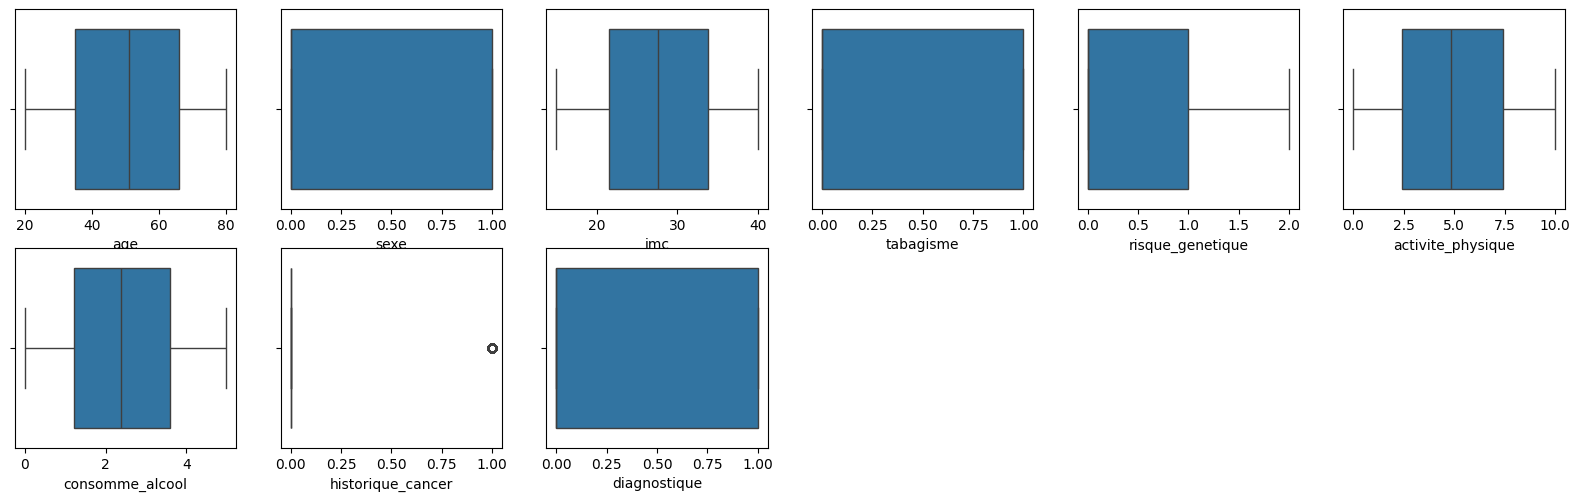

In [10]:
#Boxplot pour pour détecter les valeurs aberrantes (outliers)
plt.figure(figsize = (20, 15))
num_figure = 1

for column in dataframe:
    if num_figure <= 30:
        ax = plt.subplot(5, 6, num_figure)
        sns.boxplot(x=dataframe[column])
        plt.xlabel(column)
       
    num_figure += 1
plt.show()

### Data processing

#### Imputation des données

In [182]:
#Puisque notre dataframe ne contient aucune valeur manquante, 
# créons un dataframe factice pour étudier les différentes méthodes d'imputation
df = pd.DataFrame({
    "A": [1, 2, np.nan, 4, 5],
    "B": [10, np.nan, 30, np.nan, 50],
    "C": ["x", "y", None, "y", "y"],
    "D": [20, 15, None, 16, 18],
    "E": [0.55, 1.15, None, 2.25, 1.80]
})
df

,A,B,C,D,E
0,1.0,10.0,x,20.0,0.55
1,2.0,NaN,y,15.0,1.15
2,NaN,30.0,None,NaN,NaN
3,4.0,NaN,y,16.0,2.25
4,5.0,50.0,y,18.0,1.80


In [183]:
#Appliquons une méthode d'imputation différente à chaque colonne
df = df.assign(
    A=df["A"].fillna(df["A"].mean()),
    B=df["B"].fillna(df["B"].median()),
    C=df["C"].fillna(df["C"].mode()[0]),
    D=df["D"].interpolate(),
    E=df["E"].ffill()# Essayez bfill. f pour forward and b pour backward
)
df

,A,B,C,D,E
0,1.0,10.0,x,20.0,0.55
1,2.0,30.0,y,15.0,1.15
2,3.0,30.0,y,15.5,1.15
3,4.0,30.0,y,16.0,2.25
4,5.0,50.0,y,18.0,1.80


## Entraînement du modèle

In [11]:
X=dataframe.drop(columns=['diagnostique'], inplace=False)#Features
y=dataframe['diagnostique']#Cibles

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)

![train_test_split_schema](src/figure2.png)

Documentation logistique régression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [13]:
clf = LogisticRegression(random_state=0,max_iter=500, verbose=0,n_jobs=1)
clf.fit(X_train, y_train)#Entraînement du modèle

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [14]:
# L'accuracy du modèle. Nous renseigne sur la fiabilité du modèle.
print(f"Accuracy {clf.score(X_test, y_test)}")

Accuracy 0.88


Métriques d'évaluation du modèle

<!-- # Métriques de classification -->

Soit un problème de classification binaire avec :

- **TP** : True Positives (vrais positifs)  
- **TN** : True Negatives (vrais négatifs)  
- **FP** : False Positives (faux positifs)  
- **FN** : False Negatives (faux négatifs)  

---

#### 1. Précision (Precision)

La **précision** mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives.

$Precision=\frac{TP}{TP + FP}$

---

#### 2. Rappel (Recall)

Le **rappel** mesure la proportion de vrais positifs détectés parmi tous les positifs réels.


$Recall=\frac{TP}{TP + FN}$


---

#### 3. F1-Score

Le **F1-score** est la moyenne harmonique de la précision et du rappel :


$F1=2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$


---

#### 4. Exactitude (Accuracy)

L’**accuracy** mesure la proportion de prédictions correctes parmi toutes les prédictions.

$Accuracy= \frac{TP + TN}{TP + TN + FP + FN}$

⚠️ Attention : l’accuracy n’est pas une métrique appropriée pour évaluer un modèle entraîné sur des données contenant des classes déséquilibrées.



Exemple

![metriques](src/figure1.png)

Exemple 

In [15]:
#Rapport de classification
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       194
           1       0.86      0.79      0.82       106

    accuracy                           0.88       300
   macro avg       0.87      0.86      0.87       300
weighted avg       0.88      0.88      0.88       300



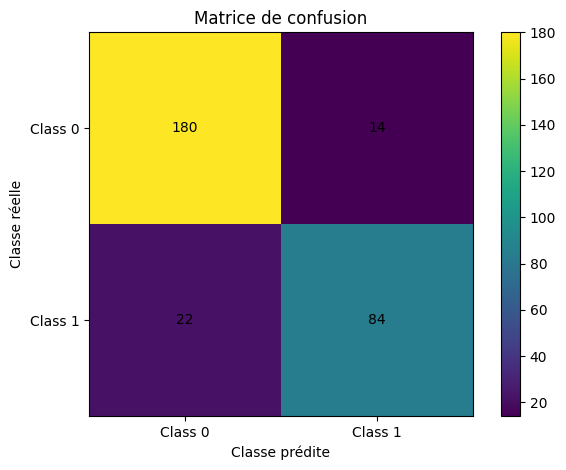

In [16]:
#Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
plt.title("Matrice de confusion")
plt.colorbar()

classes = ["Class 0", "Class 1"]
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add values inside the cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            va="center"
        )

plt.ylabel("Classe réelle")
plt.xlabel("Classe prédite")
plt.tight_layout()
plt.show()

In [28]:
#Inspectons les fonctions predict_proba et predict pour comprendre la différence.
# index=4
# clf.predict_proba(X_test)[index],clf.predict(X_test)[index]

## Optimisation du modèle

### Standardisons les données

$\bar{x}=\frac{x-u}{s}$

$u$ représente la moyenne et $s$ l'écart type.

⚠️ Attention : $u$ et $s$ sont calculés uniquement à partir des données d'entraînement.  Si nous les calculons à partir de l'ensemble des données (entraînement + validation), nous nous exposons à une fuite de données (data leakage).

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), colonnes_numeriques),
        ("cat", OrdinalEncoder(), features_categorielles)
    ]
)

In [18]:
X_train_stand = preprocessor.fit_transform(X_train)
# X_train_stand=X_train_stand.values
clf = LogisticRegression(random_state=0,max_iter=200, verbose=0,n_jobs=1)
clf.fit(X_train_stand, y_train)#Entraînement du modèle

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [20]:
X_test_stand = preprocessor.transform(X_test)
print(f"Accuracy {clf.score(X_test_stand, y_test):.2f}")

Accuracy 0.88


In [21]:
y_pred = clf.predict(X_test_stand)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       194
           1       0.87      0.79      0.83       106

    accuracy                           0.88       300
   macro avg       0.88      0.86      0.87       300
weighted avg       0.88      0.88      0.88       300



### Recherche des paramètres optimaux

In [23]:
grille_parametres = {
    "solver": ["liblinear","saga",'lbfgs'], 
    "max_iter": [100, 200, 500], 
}

In [24]:
# pd.DataFrame({
#     "paramètres": ["liblinear"]*3+["saga"]*3+["lbfgs"]*3,
#     "valeurs": [100, 200, 500]*3,
# })

Documentation GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [25]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=grille_parametres,
    scoring="f1",
    n_jobs=-1,
    cv=5,
)
grid_search.fit(X_train, y_train)

,estimator,LogisticRegre...andom_state=0)
,param_grid,"{'max_iter': [100, 200, ...], 'solver': ['liblinear', 'saga', ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [26]:
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleurcross-validation score::", grid_search.best_score_)

Meilleurs paramètres: {'max_iter': 200, 'solver': 'lbfgs'}
Meilleurcross-validation score:: 0.776238941606643


## Interprétation du modèle

Note fonction est défine comme suit:

$f(x)=\frac{1}{1+e^{-z}}$

$ z=\theta_1age + \theta_2imc + \theta_3activitephysique + \theta_4consommealcool + \theta_5sexe + \theta_6tabagisme + \theta_7risquegenetique + \theta_8historiquecancer +  \theta_9$

In [27]:
# Obtenons les paramètres de notre modèle 
print(clf.coef_)
features=colonnes_numeriques+features_categorielles
for feature,coef in zip(features,clf.coef_[0]):
    print(f"{feature}->{coef:.2f}")
print(f"Ordonnée à l'origine -> {clf.intercept_[0]:.2f}")

[[ 0.76316066  0.77214245 -0.60872815  0.76304193  1.8404053   1.7676076
   1.41431586  3.76852503]]
age->0.76
imc->0.77
activite_physique->-0.61
consomme_alcool->0.76
sexe->1.84
tabagisme->1.77
risque_genetique->1.41
historique_cancer->3.77
Ordonnée à l'origine -> -3.52



Un poids (ou coefficient) positif pour une variable signifie que plus la valeur de cette variable est élevée, plus la probabilité que le patient ait un cancer augmente. À l’inverse, un coefficient négatif indique que des valeurs plus élevées de cette variable sont associées à une probabilité plus faible de cancer.

## Enregistrement du modèle

In [28]:
np.save('weights/clf_coeficients',clf.coef_)
np.save('weights/clf_intercept',clf.intercept_)

In [29]:
#Chargement des poids du modèle
coeficients=np.load('weights/clf_coeficients.npy')
interecpt=np.load('weights/clf_intercept.npy')

In [30]:
clf_=LogisticRegression()#Initialization du modèle
clf_.coef_=coeficients#Initialization des poids du modèle avec ceux enregistrés plus haut
clf_.intercept_=interecpt#Initialization de l'ordonné aà l'origine 
clf_.classes_ = np.array([0, 1])#Définir les classes

In [31]:
print(f"Dimension d'une seule observation {X_test.values[0].shape}")
print(f"Observation redimensionner {X_test.values[0].reshape(-1,X_test.values[0].shape[0]).shape}")

Dimension d'une seule observation (8,)
Observation redimensionner (1, 8)


In [32]:
#Résultat avec le modèle dont les poids ont été chargés.
pred_=clf_.predict(X_test.values[0].reshape(-1,X_test.values[0].shape[0]))
print(pred_)

[1]


In [33]:
pred=clf.predict(X_test.values[0].reshape(-1,X_test.values[0].shape[0]))
print(pred)

[1]


In [34]:
#Une autre façon de vérifier si le chargement des poids est effectué correctement.
assert pred_==pred, "Error"

## Loguer le modèle

In [35]:
mlflow.end_run()#Sopper le run en cours si il en existe

In [ ]:
# mlflow.set_tracking_uri('http://127.0.0.1:8080')
# mlflow.set_experiment('Test')

In [38]:

# mlflow.sklearn.autolog(disable=True)
# with mlflow.start_run() as run:
#     clf = LogisticRegression(random_state=0,max_iter=100, verbose=0,n_jobs=1)
#     clf.fit(X_train, y_train)

#     # Infer the model signature
#     y_pred = clf.predict(X_test)
#     signature = infer_signature(X_test, y_pred)

#     # Log parameters and metrics using the MLflow APIs
#     # mlflow.log_params(params)
#     # mlflow.log_metrics({"mse": mean_squared_error(y_test, y_pred)})

#     # Log the sklearn model and register as version 1
#     mlflow.sklearn.log_model(
#         sk_model=clf,
#         name="sklearn-model",
#         signature=signature,
#         registered_model_name="sk-learn-random-forest-reg-model",
#     )

In [53]:
# # mlglow + gridsearch
# mlflow.sklearn.autolog()
# with mlflow.start_run(run_name="model-cancer"):
#     grid_search = GridSearchCV(
#         estimator=clf,
#         param_grid=grille_parametres,
#         scoring="f1",
#         n_jobs=-1,
#         cv=5,
#     )
#     grid_search.fit(X_train, y_train)